In [1]:
import torch
import argparse
import numpy as np
from pathlib import Path

from src.dataset import ParityPredictionDataset, HiddenParityPrediction
from src.model import TinyModel, TinyTransformer
from src.train import train_model
from src.plot import (
    plot_losses,
    plot_accuracies,
    plot_line_with_label,
    plot_list_of_lines_and_labels,
)
from src.common import get_accuracy_on_dataset

weight_decay = 1e-2
learning_rate = 1e-1
batch_size = 32
hidden_size = 1000
number_samples = 770
epochs = 400

# Replicability
np.random.seed(0)

In [2]:
# Create the training dataset
entire_dataset = HiddenParityPrediction(
    num_samples=number_samples,
    sequence_length=40,
    k=3,
)

# Split into training and validation should be 1000 and 100
train_size = int(0.90 * number_samples)
val_size = number_samples - train_size
training_dataset, validation_dataset = torch.utils.data.random_split(
    entire_dataset, [train_size, val_size])

print(f"Training dataset size: {len(training_dataset)}")
print(f"Validation dataset size: {len(validation_dataset)}")

Training dataset size: 693
Validation dataset size: 77


In [9]:
# Create the model
import torch
import torch.nn as nn
import math

class TransformerModel(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size, nhead, nlayers):
        super(TransformerModel, self).__init__()

        self.input_size = input_size
        self.hidden_layer_size = hidden_layer_size
        self.output_size = output_size

        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=self.input_size, nhead=nhead),
            num_layers=nlayers,
        )

    def forward(self, src):
        output = self.transformer_encoder(src)
        output = output.sum(dim=1) # Takes the mean across the sequence dimension
        return output

model = TransformerModel(
    input_size=40,
    hidden_layer_size=hidden_size,
    output_size=1,
    nhead=1,
    nlayers=1,
)

In [10]:
# Get one batch from the train loader
batch_size = 16
train_loader = torch.utils.data.DataLoader(
        dataset=training_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True
    )

test_batch = next(iter(train_loader))
test_input, test_output = test_batch[0], test_batch[1]
test_input.shape, test_output.shape

(torch.Size([16, 40]), torch.Size([16]))

In [11]:
model(test_input).shape

torch.Size([16])

In [12]:
(
    model,
    training_losses,
    validation_losses,
    training_accuracy,
    validation_accuracy,
    _,
) = train_model(
    training_dataset=training_dataset,
    validation_dataset=validation_dataset,
    model=model,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    epochs=epochs,
    batch_size=batch_size,
    loss_function_label="hinge",
    optimiser_function_label="sgd",
    progress_bar=True,
)

100%|██████████| 400/400 [13:42<00:00,  2.06s/it]


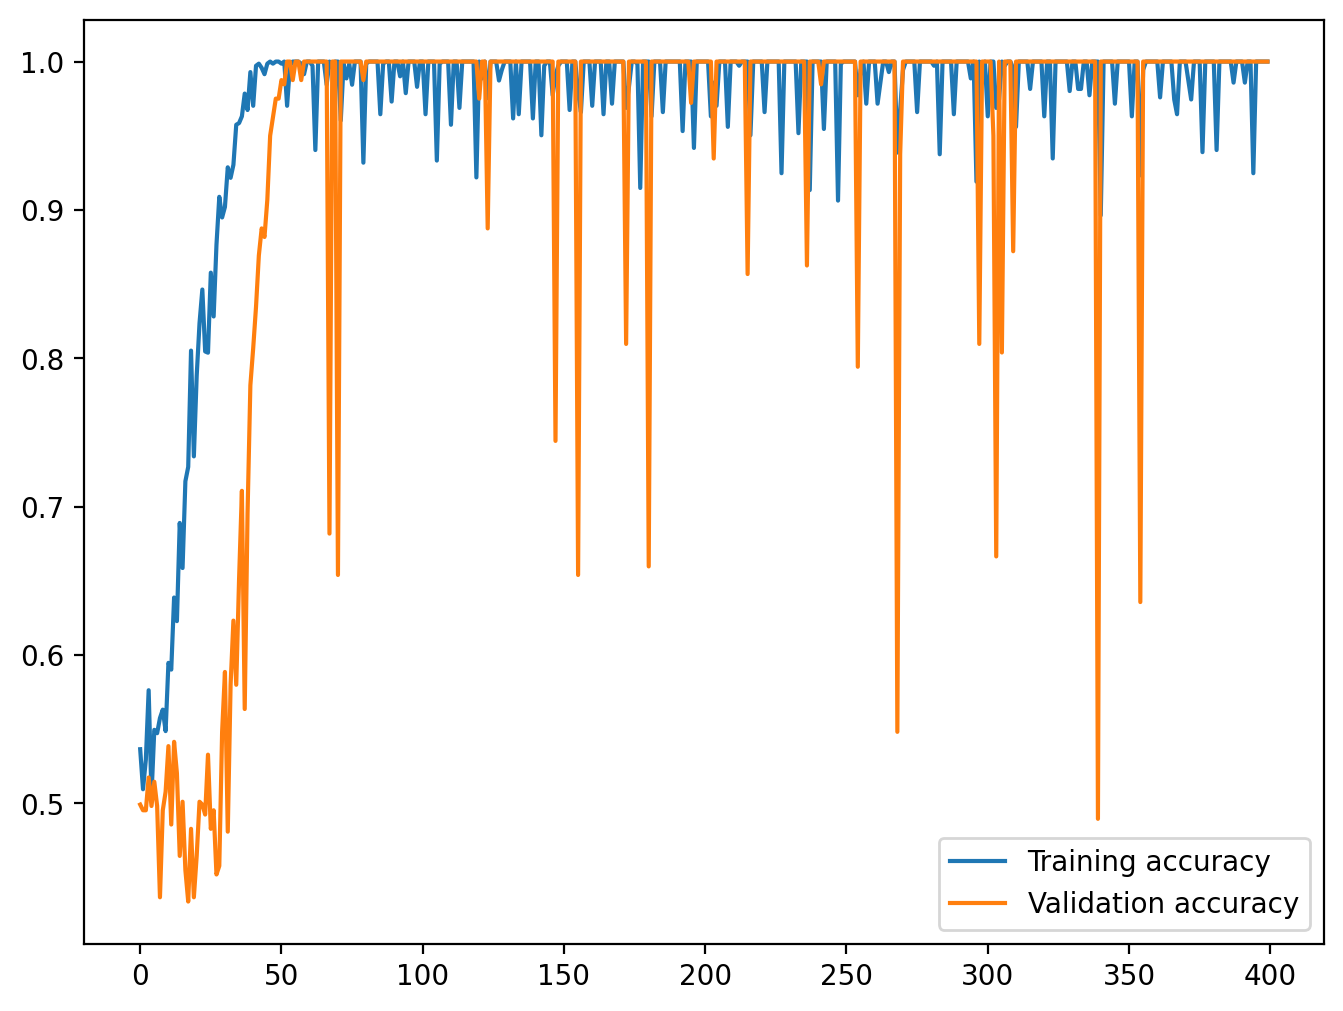

In [13]:
plot_list_of_lines_and_labels(
    lines_and_labels=[
        (training_accuracy, "Training accuracy"),
        (validation_accuracy, "Validation accuracy"),
    ],
    log=False
)

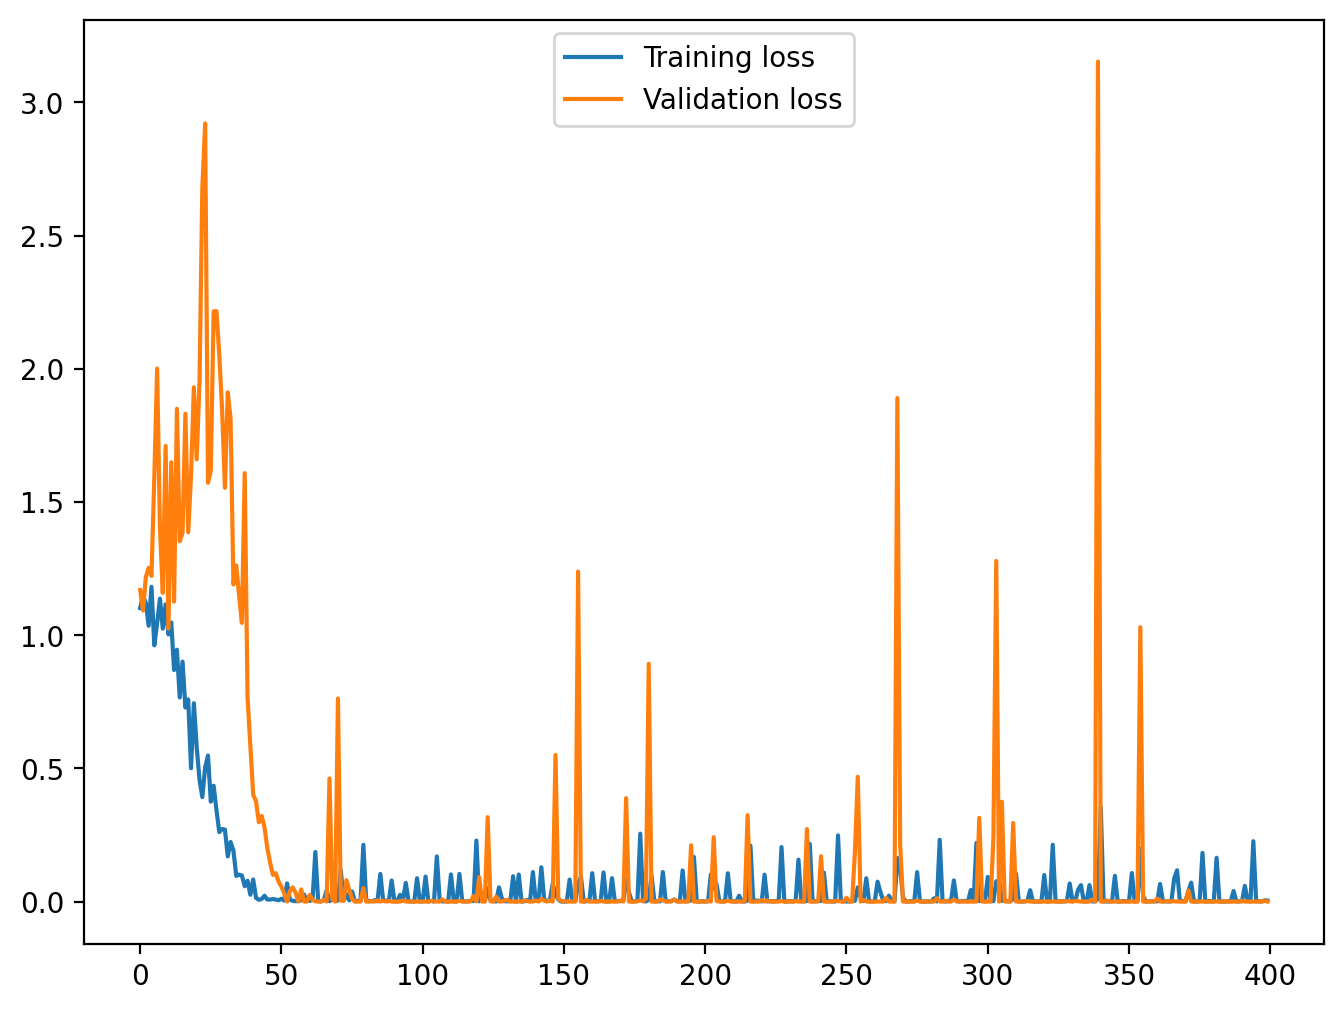

In [14]:
plot_list_of_lines_and_labels(
    lines_and_labels=[
        (training_losses, "Training loss"),
        (validation_losses, "Validation loss"),
    ],
    log=False
)